Note: deprecated

The goal of this script was to identify individual account responses to weather and use regression coefficients as inputs into kmeans clustering to group accounts by weather responsiveness.

In [13]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from timeit import default_timer as timer

In [14]:
# for parallelization if necessary
#from dask import compute, delayed
#from dask.distributed import Client, LocalCluster 
#cl = LocalCluster(n_workers=4)
#client = Client(cl)
#cl

# note: if this throws an error, close jupyter, run "ulimit -n 4096" in terminal, then restart jupyter

In [15]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

In [16]:
# read data from pickle

# what data granularity?
granularity = "hourly"

start = timer()
# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")
    
end = timer()
print((end - start)/60) # Time in minutes (~5 min for hourly data)

4.937765030883335


In [17]:
readdata.head()

,ID,DACCOUNTID,DMETERNO,Use,DCUSTOMERID,TARIFF,FUELTYPE,REVENUCODE,Dt,Weekday,MORN,DAY,EVE,NIGHT,Holiday
5316096,"(8254070687684, 606426477392)",8254070687684,606426477392,0.0,623375910664,GHC,GAS,3.0,2017-10-12,1,0,0,0,1,0
866499,"(44646997399608, 609112927596)",44646997399608,609112927596,0.0,502972276340,GH0,GAS,1.0,2017-10-12,1,0,0,0,1,0
19566499,"(152030512601272, 641385843024)",152030512601272,641385843024,0.0,1590719794684,GH0,GAS,1.0,2017-10-12,1,0,0,0,1,0
44614941,"(343435771646024, 730968557652)",343435771646024,730968557652,0.0,3508506217520,GH0,GAS,1.0,2017-10-12,1,0,0,0,1,0
34026088,"(21210824019212, 1074329744200)",21210824019212,1074329744200,0.0,272093583036,GC0,GAS,3.0,2017-10-12,1,0,0,0,1,0


In [18]:
data = readdata[np.isfinite(readdata['REVENUCODE'])] # drop NaNs from revenuecode
data = data.join(pd.get_dummies(data['REVENUCODE'].astype(np.int64), prefix='RC'))
data = data.drop(columns=['DACCOUNTID','DMETERNO','DCUSTOMERID','FUELTYPE','TARIFF','REVENUCODE','FUELTYPE'])

if granularity == "daily":
    data = pd.merge(data,
                    #looking at f statistics and AIC, this is the a good model for daily data 
                    #weather[['Dt','HighDB1','HighDB1delta','Cloud1','Cloud1delta']], 
                    weather, # looking back, I don't think we need to limit the merge here.  Can simply specify when calling regression
                    how="inner", on='Dt')
elif granularity == "hourly":
    data = pd.merge(data,
                #looking at f statistics and AIC, this is the a good model for daily data 
                # weather[['Dt','Temp1','Temp1delta','Temp2','Temp2delta','Cloud1','Cloud1delta']], 
                weather, # looking back, I don't think we need to limit the merge here.  Can simply specify when calling regression
                how="inner", on='Dt')
data = data[data.notnull()]
data = data.dropna()
data.head()

,ID,Use,Dt,Weekday,MORN,DAY,EVE,NIGHT,Holiday,RC_1,...,Cloud1,Cloud1delta,Cloud2,Cloud2delta,Cloud3,Cloud3delta,Cloud4,Cloud4delta,Cloud5,Cloud5delta
0,"(8254070687684, 606426477392)",0.0,2017-10-12,1,0,0,0,1,0,0,...,100.0,0.0,100.0,0.0,70.0,30.0,100.0,0.0,100.0,0.0
1,"(44646997399608, 609112927596)",0.0,2017-10-12,1,0,0,0,1,0,1,...,100.0,0.0,100.0,0.0,70.0,30.0,100.0,0.0,100.0,0.0
2,"(152030512601272, 641385843024)",0.0,2017-10-12,1,0,0,0,1,0,1,...,100.0,0.0,100.0,0.0,70.0,30.0,100.0,0.0,100.0,0.0
3,"(343435771646024, 730968557652)",0.0,2017-10-12,1,0,0,0,1,0,1,...,100.0,0.0,100.0,0.0,70.0,30.0,100.0,0.0,100.0,0.0
4,"(21210824019212, 1074329744200)",0.0,2017-10-12,1,0,0,0,1,0,0,...,100.0,0.0,100.0,0.0,70.0,30.0,100.0,0.0,100.0,0.0


In [19]:
list(data)

['ID',
 'Use',
 'Dt',
 'Weekday',
 'MORN',
 'DAY',
 'EVE',
 'NIGHT',
 'Holiday',
 'RC_1',
 'RC_3',
 'RC_5',
 'RC_12',
 'Temp',
 'Temp1',
 'Temp1delta',
 'Temp2',
 'Temp2delta',
 'Temp3',
 'Temp3delta',
 'Temp4',
 'Temp4delta',
 'Temp5',
 'Temp5delta',
 'Humid',
 'Humid1',
 'Humid1delta',
 'Humid2',
 'Humid2delta',
 'Humid3',
 'Humid3delta',
 'Humid4',
 'Humid4delta',
 'Humid5',
 'Humid5delta',
 'Wind',
 'Wind1',
 'Wind1delta',
 'Wind2',
 'Wind2delta',
 'Wind3',
 'Wind3delta',
 'Wind4',
 'Wind4delta',
 'Wind5',
 'Wind5delta',
 'Cloud',
 'Cloud1',
 'Cloud1delta',
 'Cloud2',
 'Cloud2delta',
 'Cloud3',
 'Cloud3delta',
 'Cloud4',
 'Cloud4delta',
 'Cloud5',
 'Cloud5delta']

## Regression ##

In [31]:
# run regression per ID tuple
import statsmodels.api as sm
import statsmodels.formula.api as smf
from timeit import default_timer as timer

start = timer()

# run regressions; add equation to table
#for idx in list(ids):
#    dat = data[data['ID']==idx]
for i in range(22,24):
    dat = data[data['ID']==ids[i]]

    if granularity == "daily":
        results = smf.ols('Use ~ LowDB1 + LowDB1delta + Cloud1 + Cloud1delta + Wind1 + Wind1delta + \
                          Weekday + Holiday + RC_1 + RC_3 + RC_5 + RC_12',
                          data=dat).fit()
    elif granularity == "hourly":
        results = smf.ols('Use ~ Temp1 + Temp1delta + Temp2delta + Temp3delta + Temp4delta + Temp5delta',
                          data=dat).fit()
    #+ Cloud1 + Cloud1delta + HR_0 + HR_1 + HR_2 + HR_3 + HR_4 + HR_5 + HR_6 + HR_7 + HR_8 + HR_9 + HR_10 + HR_11 + HR_12 + HR_13 + HR_14 + HR_15 + HR_16 + HR_17 + HR_18 + HR_19 + HR_20 + HR_21 + HR_22 + HR_23 + Weekday + Holiday + RC_1 + RC_3 + RC_5 + RC_12'
    print(results.summary())
    
end = timer()
print(end - start) # Time in seconds

                            OLS Regression Results                            
Dep. Variable:                    Use   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     139.4
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.32e-168
Time:                        12:28:32   Log-Likelihood:                -4273.4
No. Observations:                7728   AIC:                             8561.
Df Residuals:                    7721   BIC:                             8609.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0415      0.015      2.722      0.0

In [35]:
# run regression per ID tuple
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

start = timer()

#regr = linear_model.Lasso(alpha = 0.1)
regr = linear_model.LinearRegression(fit_intercept=True)

# identify subset of data to regress on
if (granularity == 'daily') | (aggregate == True):
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
else: # hourly
    features = ['Temp1', 'Temp1delta', 'Temp2delta', 'Temp3delta', 'Temp4delta', 'Temp5delta']
        
# create table of each cluster's regression equations
# ** do we want to include RMSE and R2 as parameters when clustering??
rTable = pd.DataFrame(index=list(chain.from_iterable([['intercept'], features, ['RMSE','R2']])))
# rTable = pd.DataFrame(index=list(chain.from_iterable([['intercept'], features])))

for idx in list(ids):
    X = data[data['ID']==idx][features]
    y = data[data['ID']==idx]['Use']
        
    # fit the regression model
    regr.fit(X, y)
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    #err = mean_squared_error(y, regr.predict(X))
    err = math.sqrt(mean_squared_error(y,regr.predict(X)))
    r2 = regr.score(X,y)

    rTable[idx] = [intercept]+list(chain(coefs))+[err]+[r2]
#     rTable[idx] = [intercept]+list(chain(coefs))
    
rTable = rTable.T 

end = timer()
print((end - start)/60) # Time in minutes

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


32795.408630161


In [38]:
print((end - start)/60) # Time in minutes

546.5901438360166


In [36]:
rTable.to_csv(location+'hourly_clusters.csv')
rTable

,intercept,Temp1,Temp1delta,Temp2delta,Temp3delta,Temp4delta,Temp5delta,RMSE,R2
"(665128346596, 4464578359312)",0.039731,-0.000386,-0.002128,-0.000985,-0.000758,0.000452,0.000705,0.141851,0.003506
"(819252079392, 609154378812)",0.037831,-0.000374,-0.001956,0.002094,0.000920,-0.002912,0.001654,0.137210,0.003262
"(819288717920, 4465122076620)",0.104019,-0.001185,-0.003876,0.000270,-0.000998,-0.003269,0.003291,0.201479,0.013599
"(819880484484, 4465122193056)",0.042610,-0.000054,0.002093,-0.000682,0.000836,-0.000581,-0.001387,0.208405,0.001682
"(1284453836940, 4464330738752)",0.032355,-0.000028,-0.002394,-0.004418,0.000149,-0.000455,0.005558,0.183532,0.014989
"(1286739708492, 5162227203084)",0.520199,-0.006924,0.001638,-0.008194,-0.001204,-0.002976,0.007005,0.339101,0.127447
"(1475598667620, 4968015331728)",5.528082,-0.076671,-0.059067,-0.004836,-0.021133,-0.017707,0.061136,0.838857,0.744554
"(1631154446780, 4465145519068)",0.052829,-0.000634,-0.001066,-0.000866,0.001810,0.000311,-0.001432,0.137978,0.009191
"(1633677808960, 4465140978064)",0.020578,-0.000211,0.001138,-0.000711,-0.001262,0.001242,0.000127,0.099120,0.002175
"(2680127457516, 4465121533252)",0.115432,-0.001155,-0.002757,0.000866,-0.000673,0.002143,-0.001162,0.233421,0.008787


In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

rTable_scaled = pd.DataFrame(scaler.fit_transform(rTable), columns=rTable.columns)
#rTable_scaled.to_csv(location+'daily_home_clusters_scaled.csv')
rTable_scaled

,intercept,Temp1,Temp1delta,Temp2delta,Temp3delta,Temp4delta,Temp5delta,RMSE,R2
0,-0.125960,0.135160,0.050758,0.025826,0.039130,0.052781,-0.052045,-0.073167,-0.899407
1,-0.126276,0.135363,0.051635,0.044327,0.054419,0.031194,-0.049289,-0.074066,-0.901172
2,-0.115265,0.122186,0.041885,0.033369,0.036940,0.028908,-0.044534,-0.061613,-0.826303
3,-0.125481,0.140548,0.072190,0.027648,0.053648,0.046153,-0.058119,-0.060271,-0.912613
4,-0.127187,0.140974,0.049408,0.005195,0.047392,0.046961,-0.037951,-0.065091,-0.816236
5,-0.046030,0.028980,0.069879,-0.017501,0.035058,0.030788,-0.033751,-0.034947,-0.001705
6,0.787073,-1.103754,-0.238290,0.002683,-0.146552,-0.063738,0.123442,0.061886,4.467988
7,-0.123781,0.131126,0.056151,0.026541,0.062525,0.051877,-0.058250,-0.073917,-0.858231
8,-0.129146,0.138001,0.067342,0.027471,0.034533,0.057854,-0.053722,-0.081446,-0.909046
9,-0.113367,0.122678,0.047565,0.036948,0.039901,0.063632,-0.057465,-0.055424,-0.861158


### Cluster ###

In [11]:
rTable_scaled[:1]

,intercept,Temp1,Temp1delta,Cloud1,Cloud1delta,Wind1,Wind1delta,HR_0,HR_1,HR_2,...,HR_22,HR_23,Weekday,Holiday,RC_1,RC_3,RC_5,RC_12,RMSE,R2
0,-0.117004,0.124127,0.057404,0.089468,0.092459,-0.0236,0.044804,0.056163,0.059284,0.056349,...,-0.020795,-0.008602,-0.040854,-0.009825,0.0,0.0,0.0,0.0,-0.072393,-0.911494


Text(0.5, 1.0, 'Find the elbow to identify proper K clusters')

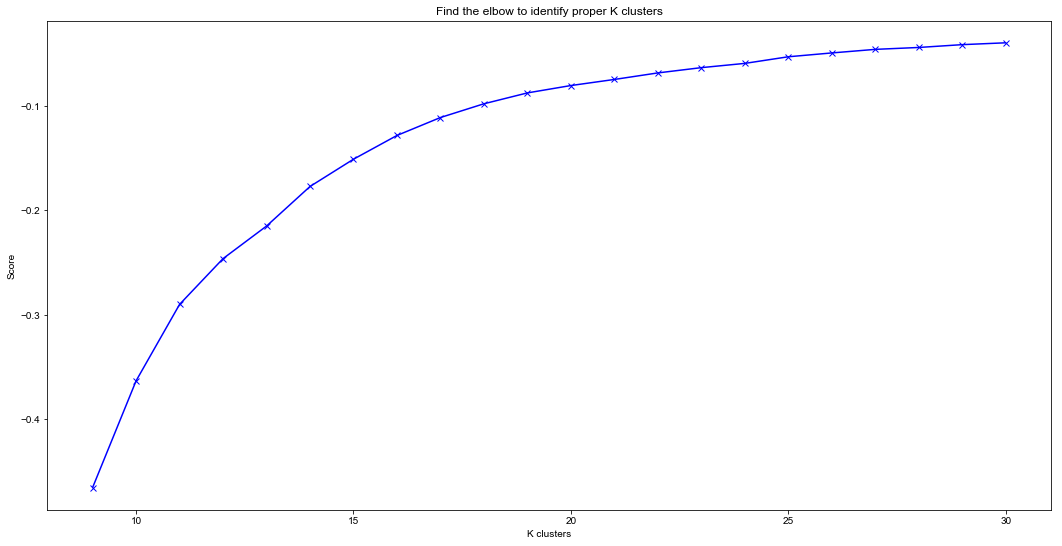

In [39]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans

# determine k using elbow method
#K = range(2,31)
K = range(9,31) # excludes outlier behavior
SSE = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    SSE.append(kmeanModel.fit(rTable_scaled).score(rTable_scaled)/len(rTable_scaled))

# scree plot - find the elbow
f, ax = plt.subplots(figsize=(18,9))
sns.set_style('whitegrid')

plt.plot(K, SSE, 'bx-')
plt.xlabel('K clusters')
plt.ylabel('Score')
plt.title('Find the elbow to identify proper K clusters')

In [40]:
from sklearn.cluster import KMeans
if granularity == "daily":
    # it looks like there's an elbow at 16
    k=16

    kmeans = KMeans(n_clusters=k, random_state=k) 
    cluster = kmeans.fit(rTable_scaled).predict(rTable_scaled)
    clust_dat = rTable
    clust_dat['cluster'] = cluster
    
    clust_dat_scaled = rTable_scaled
    clust_dat_scaled['cluster'] = cluster
if granularity == "hourly":
    # it looks like there's an elbow at 16
    k=16

    kmeans = KMeans(n_clusters=k, random_state=k) 
    cluster = kmeans.fit(rTable_scaled).predict(rTable_scaled)
    clust_dat = rTable
    clust_dat['cluster'] = cluster
    
    clust_dat_scaled = rTable_scaled
    clust_dat_scaled['cluster'] = cluster

In [41]:
clust_dat

,intercept,Temp1,Temp1delta,Temp2delta,Temp3delta,Temp4delta,Temp5delta,RMSE,R2,cluster
"(665128346596, 4464578359312)",0.039731,-0.000386,-0.002128,-0.000985,-0.000758,0.000452,0.000705,0.141851,0.003506,13
"(819252079392, 609154378812)",0.037831,-0.000374,-0.001956,0.002094,0.000920,-0.002912,0.001654,0.137210,0.003262,13
"(819288717920, 4465122076620)",0.104019,-0.001185,-0.003876,0.000270,-0.000998,-0.003269,0.003291,0.201479,0.013599,13
"(819880484484, 4465122193056)",0.042610,-0.000054,0.002093,-0.000682,0.000836,-0.000581,-0.001387,0.208405,0.001682,13
"(1284453836940, 4464330738752)",0.032355,-0.000028,-0.002394,-0.004418,0.000149,-0.000455,0.005558,0.183532,0.014989,13
"(1286739708492, 5162227203084)",0.520199,-0.006924,0.001638,-0.008194,-0.001204,-0.002976,0.007005,0.339101,0.127447,7
"(1475598667620, 4968015331728)",5.528082,-0.076671,-0.059067,-0.004836,-0.021133,-0.017707,0.061136,0.838857,0.744554,10
"(1631154446780, 4465145519068)",0.052829,-0.000634,-0.001066,-0.000866,0.001810,0.000311,-0.001432,0.137978,0.009191,13
"(1633677808960, 4465140978064)",0.020578,-0.000211,0.001138,-0.000711,-0.001262,0.001242,0.000127,0.099120,0.002175,13
"(2680127457516, 4465121533252)",0.115432,-0.001155,-0.002757,0.000866,-0.000673,0.002143,-0.001162,0.233421,0.008787,13


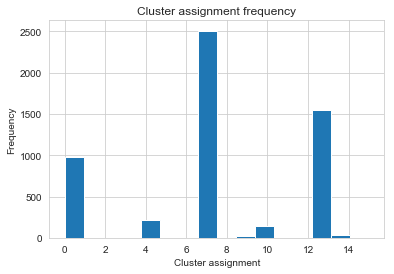

In [42]:
import matplotlib.pyplot as plt 
import seaborn as sns
# home has a much more even distribution of cluster assignments than comm!
f, ax = plt.subplots(figsize=(6,4))
sns.set_style('whitegrid')
    
plt.hist(clust_dat['cluster'], bins=k)
plt.xlabel('Cluster assignment')
plt.ylabel('Frequency')
plt.title('Cluster assignment frequency')
plt.show() 

In [43]:
clust_dat[['cluster','intercept']].groupby('cluster').count()

,intercept
cluster,
0,982
1,2
2,1
3,1
4,212
5,1
6,1
7,2508
8,1


In [44]:
# quick look at who's who
clust_dat[clust_dat['cluster']==8]

,intercept,Temp1,Temp1delta,Temp2delta,Temp3delta,Temp4delta,Temp5delta,RMSE,R2,cluster
"(308811586562460, 2613828993176)",17.263542,0.542256,0.108493,-1.309005,-0.640225,0.387013,7.51889,106.932146,0.160913,8


In [45]:
# Daily: Try sub-clustering w/in cluster 15?  
# Probably not worth it; the initial error is already quite low indicating this truly is a cohesive group
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans

if granularity == "daily":
    # determine k using elbow method
    K = range(1,20)
    #K = range(9,31) # excludes outlier behavior
    SSE = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        SSE.append(kmeanModel.fit(clust_dat_scaled[clust_dat_scaled['cluster']==15])
                   .score(clust_dat_scaled[clust_dat_scaled['cluster']==15])/len(clust_dat_scaled))

    # scree plot - find the elbow
    f, ax = plt.subplots(figsize=(18,9))
    sns.set_style('whitegrid')

    plt.plot(K, SSE, 'bx-')
    plt.xlabel('K clusters')
    plt.ylabel('Score')
    plt.title('Find the elbow to identify proper K clusters')

### Visualize clusters ###

In [48]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

# PCA
pca = decomposition.PCA(n_components=5,whiten=False)
X = pca.fit_transform(rTable[['intercept','Temp1','Temp1delta','Temp2delta','Temp3delta','Temp4delta','Temp5delta']])

print("PCA % Variance Explained:\n{}:".format(pca.explained_variance_ratio_))
# print(pca.explained_variance_)
# print("PCA Components:\n{}:".format(pca.components_))

PCA % Variance Explained:
[9.98849916e-01 8.06857056e-04 2.53160654e-04 8.06598928e-05
 6.33261286e-06]:


Text(0, 0.5, 'Principal Components')

<Figure size 720x720 with 0 Axes>

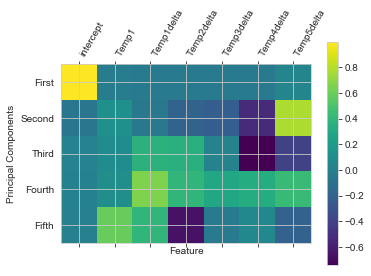

In [50]:
# visualize pcas
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(10,10))
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1,2,3,4], ['First','Second','Third','Fourth','Fifth'])
plt.colorbar()
plt.xticks(range(len(list(rTable[['intercept','Temp1','Temp1delta','Temp2delta','Temp3delta','Temp4delta','Temp5delta']]))),
           list(rTable), rotation = 60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal Components')

Text(0, 0.5, 'Second PC')

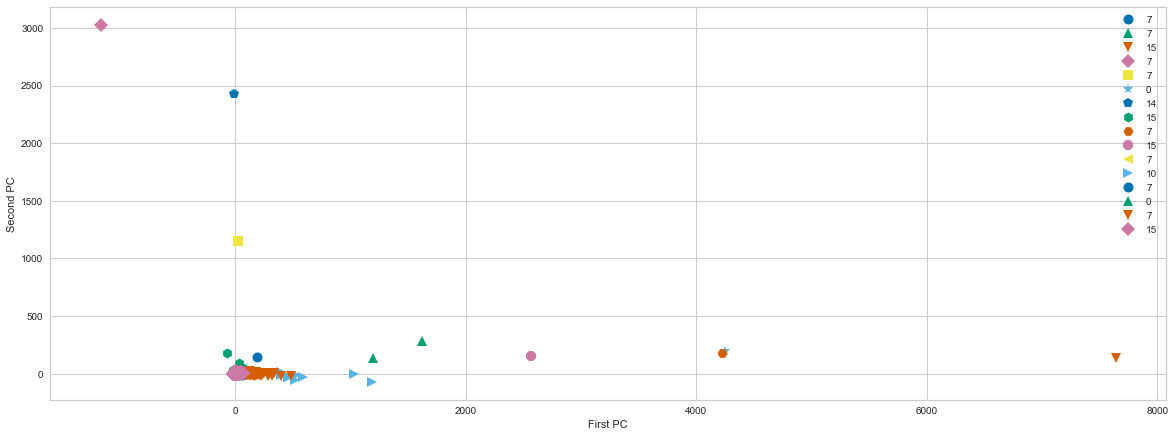

In [99]:
# visualize cluster identities using PCA on weight vector
from sklearn import decomposition
import mglearn

# PCA
pca = decomposition.PCA(n_components=5,whiten=False)
pcaX = pca.fit_transform(rTable)

# Specify the features of interest and the target
target = "cluster"
features = [col for col in rTable.columns if col != target]

# Extract the instance data and the target
X = rTable[features]
y = rTable[target]

plt.figure(figsize=(20,20))
mglearn.discrete_scatter(pcaX[:,0], pcaX[:,1], y)
plt.legend(y)
plt.gca().set_aspect("equal")
plt.xlabel("First PC")
plt.ylabel("Second PC")
# X_pca_1cw = pca1.fit_transform(data_scaled)
# plt.scatter(X_pca_1cw[:,0], X_pca_1cw[:,1], c=iris.target,
# alpha=0.8, s=60, marker='o', edgecolors='white')
# plt.show()
# pca_2cw.explained_variance_ratio_.sum() 


# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plt.cla()

<Figure size 480x480 with 0 Axes>

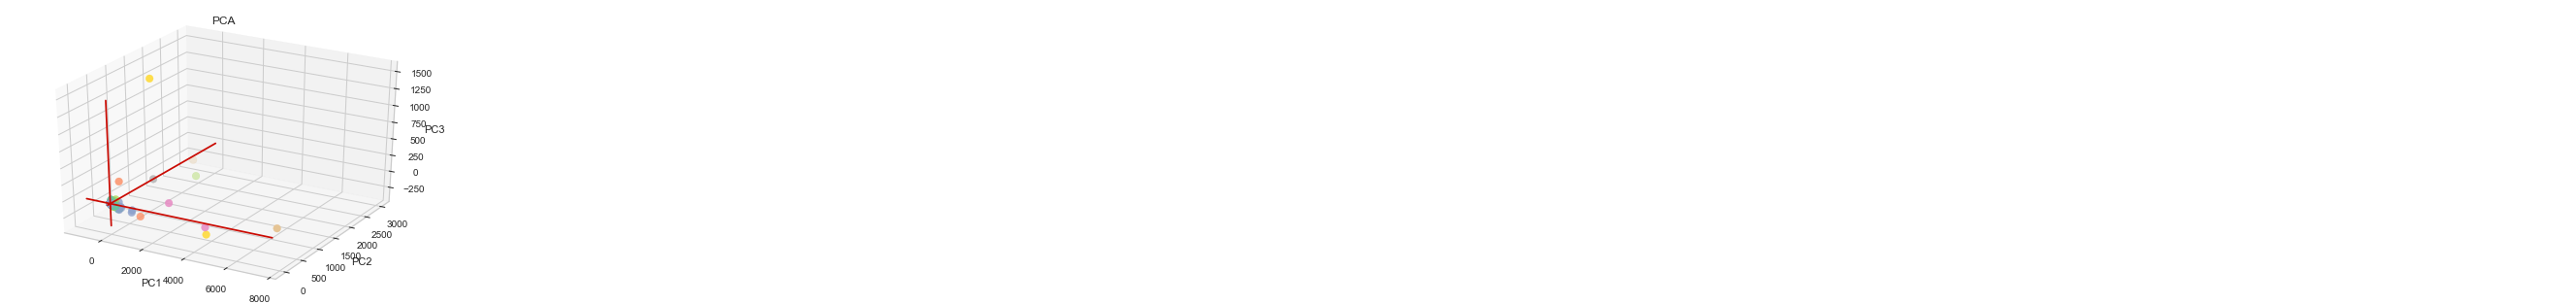

In [106]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_style('whitegrid')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# Keep the 'specie' column appart + make it numeric for coloring
df = rTable
df['cluster'] = pd.Categorical(df['cluster'])
my_color = df['cluster'].cat.codes
df = df.drop(columns='cluster')
# df = sns.load_dataset('iris')
# df['species']=pd.Categorical(df['species'])
# my_color=df['species'].cat.codes
# df = df.drop('species', 1)
 
# Run The PCA
pca = PCA(n_components=3)
pca.fit(df)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA")
plt.show()


In [ ]:
# visualize rate-code identities using PCA on weight vector

In [ ]:
# append cluster ID to daily/hourly set

In [ ]:
# close dask cluster (if used)
#cl.close